### Rain prediction - testing / sandbox (Prophet forecast)

This is a collection of experiments with the company's local weather station data + enriched with Open Meteo API historical weather data. The Open Meteo historical data will "simulate" future predictions, which might make the results overly optimistic.

In the best scenario, we should use conventional weather forecasts from an API and use those variables as extra regressors instead.

In [25]:
import pandas as pd
import phik

# pip install prophet
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler



**Step 1: Open the local weather station data**

In [26]:
# [EXPERIMENT IDEA]: try different timeframes and weather station locations
# in order to see if the results differ considerably
# adjust the filepath to your workstation
path = r"c:\Users\KDD\Downloads"
df = pd.read_csv(path + r"\WS100\Data\Saaritie\Saaritie_202501-202509.csv", delimiter=";")

# used later for a trick where we compare correlation matrix + phik -matrix
original_weather_columns = list(df.columns)
original_weather_columns.remove("Timestamp")

df.head()

,Timestamp,precipitationIntensity_mm_h,precipitationIntensity_mm_min,precipitationQuantityAbs_mm,precipitationQuantityDiff_mm,precipitationType
0,2025-01-01 00:09:27,0.0,0.0,44.1,0.0,0
1,2025-01-01 00:19:27,0.0,0.0,44.1,0.0,0
2,2025-01-01 00:29:27,0.0,0.0,44.1,0.0,0
3,2025-01-01 00:39:28,0.0,0.0,44.1,0.0,0
4,2025-01-01 00:49:28,0.0,0.0,44.1,0.0,0


In [27]:
# re-adjust our dataset so instead of 10min interval
# we use 1 hour interval
# this is needed since open meteo data is in 1 hour intervals

# [EXPERIMENT IDEA]: we are using 1 hour as the common time step here
# Open Meteo API also provides some of the variables in 15 minute intervals
# this would allow us to use 30min intervals in the combined data later
# since 30 minutes is the nearest common even numerator for both 10 and 15 minutes
# see "15-Minutely Weather Variables" in the Open Meteo API

# convert to pandas DateTime-format for easier manipulation
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# round timestamp  to nearest hour and aggregate (group by) with average values
df["rounded_hour"] = df["Timestamp"].dt.round("h")
df_hourly = df.groupby("rounded_hour").mean(numeric_only=True).reset_index()
df_hourly = df_hourly.rename(columns={"rounded_hour": "Timestamp"})

# sanity check, did this work correctly?
df_hourly.head(3)

,Timestamp,precipitationIntensity_mm_h,precipitationIntensity_mm_min,precipitationQuantityAbs_mm,precipitationQuantityDiff_mm,precipitationType
0,2025-01-01 00:00:00,0.0,0.0,44.1,0.0,0.0
1,2025-01-01 01:00:00,0.0,0.0,44.1,0.0,0.0
2,2025-01-01 02:00:00,0.0,0.0,44.1,0.0,0.0


Unfortunately some of the important variables (soil moisture etc.) seem to be missing in the 15 minute data options.

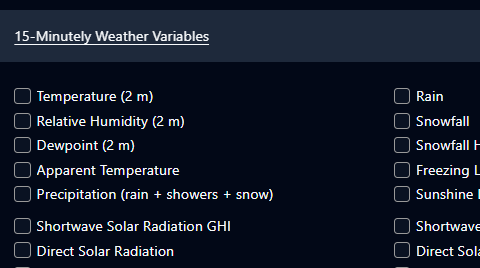

**Step 2: Get additional weather data from Open Meteo**

See API:
https://open-meteo.com/en/docs/historical-forecast-api

**NOTE:** when you download a CSV-file from Open Meteo, you have some meta information on top of the CSV-file, which you have to remove before you load it into pandas.

You can just open the csv-file in a Notepad or something similar, and remove the first rows until the real data begins. In the example below, the first three rows need to be deleted.

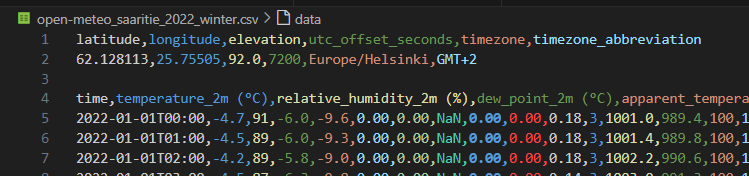

In [28]:
# using a CSV snapshot from autumn 2024 somewhere in Jyväskylä

# [EXPERIMENT IDEA]: try different locations and location data, or a location that is 
# as close to your local weather station as possible

# load data snapshot and rename columns
df_meteo = pd.read_csv(path+"\open-meteo\open-meteo-saaritie.csv")
df_meteo = df_meteo.rename(columns={"time": "Timestamp"})
df_meteo["Timestamp"] = pd.to_datetime(df_meteo["Timestamp"])

# round timestamp  to nearest hour and aggregate (group by) with average values
df_meteo["rounded_hour"] = df_meteo["Timestamp"].dt.round("h")
df_meteo_avg = df_meteo.groupby("rounded_hour").mean(numeric_only=True).reset_index()
df_meteo_avg = df_meteo_avg.rename(columns={"rounded_hour": "Timestamp"})

# df_meteo["time"] = pd.to_datetime(df_meteo["time"])
# df_meteo = df_meteo.rename(columns={"time": "Timestamp"})
# df_meteo.head(3)
df_meteo_avg.head(3)

<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
C:\Users\KDD\AppData\Local\Temp\ipykernel_3888\4076817246.py:7: SyntaxWarning: invalid escape sequence '\o'
  df_meteo = pd.read_csv(path+"\open-meteo\open-meteo-saaritie.csv")


,Timestamp,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),precipitation (mm),rain (mm),surface_pressure (hPa),evapotranspiration (mm),soil_moisture_27_to_81cm (m³/m³),soil_moisture_9_to_27cm (m³/m³),...,cloud_cover_mid (%),cloud_cover_low (%),cloud_cover (%),pressure_msl (hPa),weather_code (wmo code),snow_depth (m),showers (mm),snowfall (cm),precipitation_probability (%),dew_point_2m (°C)
0,2025-01-01 00:00:00,-5.8,88.0,-10.4,0.0,0.0,993.0,0.0,0.350,0.316,...,99.0,5.0,100.0,1002.8,3.0,0.19,0.0,0.0,NaN,-7.4
1,2025-01-01 01:00:00,-5.3,88.0,-9.8,0.0,0.0,992.0,0.0,0.350,0.316,...,100.0,20.0,100.0,1001.8,3.0,0.19,0.0,0.0,NaN,-6.9
2,2025-01-01 02:00:00,-4.8,88.0,-9.1,0.0,0.0,991.2,0.0,0.349,0.315,...,100.0,81.0,100.0,1001.0,3.0,0.19,0.0,0.0,NaN,-6.4


**Step 3: Combine (merge) the Local weather station and Open Meteo Data**

In [29]:
# merge data and see if we still have the correct amount of data
# sometimes after merge we either lose most data or exponentially increase the amount of data
# typically you want to have exact same amount of rows BEFORE and AFTER merging
merged = pd.merge(df_hourly, df_meteo_avg, on="Timestamp", how="left")
merged = merged.dropna()
merged

,Timestamp,precipitationIntensity_mm_h,precipitationIntensity_mm_min,precipitationQuantityAbs_mm,precipitationQuantityDiff_mm,precipitationType,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),precipitation (mm),...,cloud_cover_mid (%),cloud_cover_low (%),cloud_cover (%),pressure_msl (hPa),weather_code (wmo code),snow_depth (m),showers (mm),snowfall (cm),precipitation_probability (%),dew_point_2m (°C)
3996,2025-06-23 03:00:00,0.000000,0.000000,152.290000,0.000,0.0,10.4,94.0,9.7,0.0,...,0.0,0.0,90.0,1011.4,3.0,0.0,0.0,0.0,0.0,9.5
3997,2025-06-23 04:00:00,0.000000,0.000000,152.290000,0.000,0.0,12.0,84.0,10.7,0.0,...,13.0,5.0,100.0,1010.9,3.0,0.0,0.0,0.0,0.0,9.4
3998,2025-06-23 05:00:00,0.000000,0.000000,152.290000,0.000,0.0,13.9,76.0,12.6,0.0,...,0.0,2.0,99.0,1010.4,3.0,0.0,0.0,0.0,0.0,9.8
3999,2025-06-23 06:00:00,0.000000,0.000000,152.290000,0.000,0.0,15.7,67.0,14.2,0.0,...,1.0,0.0,99.0,1009.8,3.0,0.0,0.0,0.0,0.0,9.6
4000,2025-06-23 07:00:00,0.000000,0.000000,152.290000,0.000,0.0,16.7,60.0,14.6,0.0,...,94.0,0.0,100.0,1009.3,3.0,0.0,0.0,0.0,0.0,8.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6082,2025-09-18 05:00:00,0.000000,0.000000,305.310000,0.000,0.0,12.7,93.0,11.9,0.0,...,10.0,100.0,78.0,1005.3,2.0,0.0,0.0,0.0,6.0,11.6
6083,2025-09-18 06:00:00,0.000000,0.000000,305.310000,0.000,0.0,13.2,90.0,12.3,0.0,...,0.0,100.0,100.0,1005.7,3.0,0.0,0.0,0.0,0.0,11.6
6084,2025-09-18 07:00:00,0.000000,0.000000,305.310000,0.000,0.0,13.8,86.0,12.5,0.0,...,0.0,100.0,85.0,1005.6,3.0,0.0,0.0,0.0,8.0,11.5
6085,2025-09-18 08:00:00,0.016667,0.000333,305.310000,0.000,20.0,14.5,86.0,13.1,0.0,...,0.0,100.0,100.0,1005.8,3.0,0.0,0.0,0.0,23.0,12.2


In [30]:
# finally, replace our active DataFrame with the merged-version
df = merged

**Time-series datasets should be regular => uniform intervals without any missing parts of sequence (in our case, no missing hours in any day, because this breaks the signal)**

Note: for ML models, sequence is just a sequence. It doesn't inherently know if parts of the sequence are missing in real life. In our case, missing hours means we have missing measurement events in the data.

In [31]:
# final check, is our time series dataset regular (even steps with no missing hours)
diffs = df['Timestamp'].diff()
is_regular = diffs.iloc[1:].eq(pd.Timedelta('1h')).all()
print(is_regular)
print()

#if there are gaps, identify where they are:
gaps = df.loc[diffs > pd.Timedelta('1h'), 'Timestamp']
print("Missing indeces:")
print(gaps)

False

Missing indeces:
5386   2025-08-20 05:00:00
Name: Timestamp, dtype: datetime64[ns]


In [32]:
# re-index for interpolation
df = df.set_index('Timestamp').sort_index()
full_index = pd.date_range(df.index.min(), df.index.max(), freq='h')
df = df.reindex(full_index)

# DOUBLE-CHECK THAT THIS INTERPOLATION WORKED CORRECTLY

# interpolate and reset index
df = df.interpolate(method='time')
df = df.reset_index().rename(columns={'index': 'Timestamp'})

**Step 4: Prophet forecasting**

In [33]:
# Prophet requires a certain naming convention
# ds => timestamp field / sequence number => has to be in DateTime-format (pandas)
# y => target variable
# support variables / extra regressors can be called as they are

# PROPHET REQUIRES A NAMING CONVENTION
# target is y , timestamp is ds

# [EXPERIMENT IDEA]: try a different local weather station rain variable
# for prediction. this one uses precipitation intensity in mm per hour

# fix the column names to match better with Prophet requirements
df = df.rename({"precipitationIntensity_mm_h": "y", "Timestamp": "ds"}, axis=1)
df['ds'] = pd.to_datetime(df['ds'], format="mixed")
df_original = df.copy()
df

,ds,y,precipitationIntensity_mm_min,precipitationQuantityAbs_mm,precipitationQuantityDiff_mm,precipitationType,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),precipitation (mm),...,cloud_cover_mid (%),cloud_cover_low (%),cloud_cover (%),pressure_msl (hPa),weather_code (wmo code),snow_depth (m),showers (mm),snowfall (cm),precipitation_probability (%),dew_point_2m (°C)
0,2025-06-23 03:00:00,0.000000,0.000000,152.290000,0.000,0.0,10.4,94.0,9.7,0.0,...,0.0,0.0,90.0,1011.4,3.0,0.0,0.0,0.0,0.0,9.5
1,2025-06-23 04:00:00,0.000000,0.000000,152.290000,0.000,0.0,12.0,84.0,10.7,0.0,...,13.0,5.0,100.0,1010.9,3.0,0.0,0.0,0.0,0.0,9.4
2,2025-06-23 05:00:00,0.000000,0.000000,152.290000,0.000,0.0,13.9,76.0,12.6,0.0,...,0.0,2.0,99.0,1010.4,3.0,0.0,0.0,0.0,0.0,9.8
3,2025-06-23 06:00:00,0.000000,0.000000,152.290000,0.000,0.0,15.7,67.0,14.2,0.0,...,1.0,0.0,99.0,1009.8,3.0,0.0,0.0,0.0,0.0,9.6
4,2025-06-23 07:00:00,0.000000,0.000000,152.290000,0.000,0.0,16.7,60.0,14.6,0.0,...,94.0,0.0,100.0,1009.3,3.0,0.0,0.0,0.0,0.0,8.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2090,2025-09-18 05:00:00,0.000000,0.000000,305.310000,0.000,0.0,12.7,93.0,11.9,0.0,...,10.0,100.0,78.0,1005.3,2.0,0.0,0.0,0.0,6.0,11.6
2091,2025-09-18 06:00:00,0.000000,0.000000,305.310000,0.000,0.0,13.2,90.0,12.3,0.0,...,0.0,100.0,100.0,1005.7,3.0,0.0,0.0,0.0,0.0,11.6
2092,2025-09-18 07:00:00,0.000000,0.000000,305.310000,0.000,0.0,13.8,86.0,12.5,0.0,...,0.0,100.0,85.0,1005.6,3.0,0.0,0.0,0.0,8.0,11.5
2093,2025-09-18 08:00:00,0.016667,0.000333,305.310000,0.000,20.0,14.5,86.0,13.1,0.0,...,0.0,100.0,100.0,1005.8,3.0,0.0,0.0,0.0,23.0,12.2


**OPTIONAL: You can also attempt using a filter (SavGol, Kalman etc.) in order to simplify the rain signal**

Just remember: traditional (electronics) filter methods are usually irreversible => we can't reliably convert back to actual rain amounts after filtering has been performed.

[EXPERIMENT IDEA]:
However, it might be possible to save the original values somewhere first, so we could estimate which average real value a filtered value would mean in the original scope.

In [34]:
# # optional test.... Savgol filter
# from scipy.signal import savgol_filter

# # [EXPERIMENT IDEA]: adjust the window length, polyorder to adjust aggressiveness 
# # of the Savitzky-Golay filter. Or just try another filter, like Kalman

# # see this notebook for other filter/analysis ideas:
# # https://colab.research.google.com/drive/1yAeDBAPuhxg0-OgIsTB4pLggwCg4yl8k?usp=sharing

# # apply Savitzky-Golay filter with a window size and polynomial order
# # original values used with this code example: window_length = 6, polyorder = 5
# df['signal_smooth_sg'] = savgol_filter(df['y'], window_length=36, polyorder=12)

# # plot the original and smoothed data
# plt.plot(df['y'], label='Original signal')
# plt.plot(df['signal_smooth_sg'], label='Savitzky-Golay Smoothed Signal', linestyle='--')
# plt.legend()
# plt.show()

# # replace original with SavGol and save original y for later purposes
# # df_original = pd.DataFrame(df['y'].copy())
# df['y'] = df['signal_smooth_sg']

In [35]:
df

,ds,y,precipitationIntensity_mm_min,precipitationQuantityAbs_mm,precipitationQuantityDiff_mm,precipitationType,temperature_2m (°C),relative_humidity_2m (%),apparent_temperature (°C),precipitation (mm),...,cloud_cover_mid (%),cloud_cover_low (%),cloud_cover (%),pressure_msl (hPa),weather_code (wmo code),snow_depth (m),showers (mm),snowfall (cm),precipitation_probability (%),dew_point_2m (°C)
0,2025-06-23 03:00:00,0.000000,0.000000,152.290000,0.000,0.0,10.4,94.0,9.7,0.0,...,0.0,0.0,90.0,1011.4,3.0,0.0,0.0,0.0,0.0,9.5
1,2025-06-23 04:00:00,0.000000,0.000000,152.290000,0.000,0.0,12.0,84.0,10.7,0.0,...,13.0,5.0,100.0,1010.9,3.0,0.0,0.0,0.0,0.0,9.4
2,2025-06-23 05:00:00,0.000000,0.000000,152.290000,0.000,0.0,13.9,76.0,12.6,0.0,...,0.0,2.0,99.0,1010.4,3.0,0.0,0.0,0.0,0.0,9.8
3,2025-06-23 06:00:00,0.000000,0.000000,152.290000,0.000,0.0,15.7,67.0,14.2,0.0,...,1.0,0.0,99.0,1009.8,3.0,0.0,0.0,0.0,0.0,9.6
4,2025-06-23 07:00:00,0.000000,0.000000,152.290000,0.000,0.0,16.7,60.0,14.6,0.0,...,94.0,0.0,100.0,1009.3,3.0,0.0,0.0,0.0,0.0,8.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2090,2025-09-18 05:00:00,0.000000,0.000000,305.310000,0.000,0.0,12.7,93.0,11.9,0.0,...,10.0,100.0,78.0,1005.3,2.0,0.0,0.0,0.0,6.0,11.6
2091,2025-09-18 06:00:00,0.000000,0.000000,305.310000,0.000,0.0,13.2,90.0,12.3,0.0,...,0.0,100.0,100.0,1005.7,3.0,0.0,0.0,0.0,0.0,11.6
2092,2025-09-18 07:00:00,0.000000,0.000000,305.310000,0.000,0.0,13.8,86.0,12.5,0.0,...,0.0,100.0,85.0,1005.6,3.0,0.0,0.0,0.0,8.0,11.5
2093,2025-09-18 08:00:00,0.016667,0.000333,305.310000,0.000,20.0,14.5,86.0,13.1,0.0,...,0.0,100.0,100.0,1005.8,3.0,0.0,0.0,0.0,23.0,12.2


**Scaling the values**

In [36]:
# initialize scaler
scaler = MinMaxScaler()

# save the original min/max so we can convert the Prophet's output
# back to original values later...
# ~you can use inverse-transform with this as well
# y_min = df['y'].min()
# y_max = df['y'].max()

df['y'] = scaler.fit_transform(df[['y']])

**Take a smaller subset of the data, e.g. 100 points**

In [37]:
# Keep full dataset before slicing
df_full = df.copy()

# 2000 is a good index, 500 also, 1600 is super cool with SavGol!!
# problematic index => 3150
# around 150, lots of problems
# only take 100 points, let's experiment on that

# [EXPERIMENT IDEA]: adjust the index slice size, how about 50, 100, 150, 200...?

# the cutoff point for index 
index_cut = 100
slice_length = 100

# take a slice, this uses 100 points
df = df_full.iloc[index_cut:index_cut + slice_length].copy()
print(f"Amount of selected data points: {len(df)}")

Amount of selected data points: 100


**Optional: Visualize the whole dataset**

You can uncomment this block of code if you just want to see the whole dataset at once.

In [38]:
# # plot everything we have
# df_copy = df.copy()
# df_copy['sequence'] = df_copy.index + 1
# df_copy = df_copy.drop(['ds'], axis=1)
# df_copy.set_index("sequence", inplace=True)

# plt.figure(figsize=(12, 6))

# for column in df_copy.columns:
#     plt.plot(df_copy.index, df_copy[column], label=column)

# plt.title("All continuous variables")
# plt.xlabel("Time")
# plt.ylabel("Value")

# plt.legend(title="Variables")
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()

In [39]:
# Got this from ChatGPT, study both at the same time!

# we need jinja2 for visualizations
# pip install jinja2
cols_to_use = [c for c in df.columns if c not in original_weather_columns]
cols_to_use.remove("ds")

savgol_used = False

# remove the SavGol-signal from original weather columns list if present
if "signal_smooth_sg" in cols_to_use:
    cols_to_use.remove("signal_smooth_sg")
    savgol_used = True

# only use the variables not in the original local weather station
corr_pearson = df[cols_to_use].corr()['y']
corr_phik = df[cols_to_use].phik_matrix()['y']

# if you wish to see the original local weather station variables too, try:
# corr_pearson = df.corr()['y']
# corr_phik = df.phik_matrix()['y']

comparison = pd.concat([corr_pearson, corr_phik], axis=1)
comparison.columns = ['Pearson', 'Phik']
comparison = comparison.sort_values('Phik', ascending=False)

comparison.style.background_gradient(cmap='coolwarm', axis=0).set_caption("Pearson vs Phik Correlations with y")


interval columns not set, guessing: ['y', 'temperature_2m (°C)', 'relative_humidity_2m (%)', 'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)', 'surface_pressure (hPa)', 'evapotranspiration (mm)', 'soil_moisture_27_to_81cm (m³/m³)', 'soil_moisture_9_to_27cm (m³/m³)', 'soil_moisture_3_to_9cm (m³/m³)', 'soil_moisture_0_to_1cm (m³/m³)', 'soil_moisture_1_to_3cm (m³/m³)', 'soil_temperature_54cm (°C)', 'soil_temperature_18cm (°C)', 'soil_temperature_6cm (°C)', 'soil_temperature_0cm (°C)', 'wind_speed_10m (km/h)', 'wind_speed_80m (km/h)', 'wind_speed_120m (km/h)', 'wind_speed_180m (km/h)', 'wind_direction_10m (°)', 'wind_direction_80m (°)', 'wind_direction_120m (°)', 'wind_direction_180m (°)', 'wind_gusts_10m (km/h)', 'temperature_80m (°C)', 'temperature_120m (°C)', 'temperature_180m (°C)', 'vapour_pressure_deficit (kPa)', 'et0_fao_evapotranspiration (mm)', 'visibility (m)', 'cloud_cover_high (%)', 'cloud_cover_mid (%)', 'cloud_cover_low (%)', 'cloud_cover (%)', 'pressure_msl (hP

c:\Users\KDD\Documents\ML_Project2025\.venv\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable snow_depth (m) for analysis 1. Dropping this column
  warnings.warn(
c:\Users\KDD\Documents\ML_Project2025\.venv\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable showers (mm) for analysis 1. Dropping this column
  warnings.warn(
c:\Users\KDD\Documents\ML_Project2025\.venv\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable snowfall (cm) for analysis 1. Dropping this column
  warnings.warn(


,Pearson,Phik
y,1.000000,1.000000
soil_moisture_0_to_1cm (m³/m³),0.255634,0.834136
wind_direction_180m (°),-0.256858,0.826896
precipitation (mm),0.396652,0.767227
rain (mm),0.396652,0.767227
cloud_cover_mid (%),0.066331,0.702989
wind_direction_10m (°),-0.249805,0.669734
pressure_msl (hPa),-0.213764,0.635123
surface_pressure (hPa),-0.214429,0.620337
soil_moisture_1_to_3cm (m³/m³),0.297442,0.563278


REMEMBER! You shouldn't use local weather station variables as regressors, because we'll never have conventional weather forecasts for these variables in production (only use the external Open Meteo variables!)

In [40]:
# let's quickly see what our options are for extra regressors
df[cols_to_use].columns

Index(['y', 'temperature_2m (°C)', 'relative_humidity_2m (%)',
       'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)',
       'surface_pressure (hPa)', 'evapotranspiration (mm)',
       'soil_moisture_27_to_81cm (m³/m³)', 'soil_moisture_9_to_27cm (m³/m³)',
       'soil_moisture_3_to_9cm (m³/m³)', 'soil_moisture_0_to_1cm (m³/m³)',
       'soil_moisture_1_to_3cm (m³/m³)', 'soil_temperature_54cm (°C)',
       'soil_temperature_18cm (°C)', 'soil_temperature_6cm (°C)',
       'soil_temperature_0cm (°C)', 'wind_speed_10m (km/h)',
       'wind_speed_80m (km/h)', 'wind_speed_120m (km/h)',
       'wind_speed_180m (km/h)', 'wind_direction_10m (°)',
       'wind_direction_80m (°)', 'wind_direction_120m (°)',
       'wind_direction_180m (°)', 'wind_gusts_10m (km/h)',
       'temperature_80m (°C)', 'temperature_120m (°C)',
       'temperature_180m (°C)', 'vapour_pressure_deficit (kPa)',
       'et0_fao_evapotranspiration (mm)', 'visibility (m)',
       'cloud_cover_high (%)', 'cloud_

In [41]:
# initialize the model and add helper variables
# disable seasonality features, because within 100 hours
# there's not much seasonality going on here
# changepoint_prior_scale affects trend smoothness
# [EXPERIMENT IDEA]: try adjusting the prior scale value
model = Prophet(scaling='minmax', 
                yearly_seasonality=False,
                weekly_seasonality=False,
                daily_seasonality=False,
                seasonality_mode='additive',  
                changepoint_prior_scale=0.01)


# [EXPERIMENT IDEA]: try different extra regressors 
# See the colored Pearson / Phik-matrix tool in order to
# see what variables seem to be the most impactful one this time

# put our regressor variable names into a list for easier experimentation
regressors = [
              "dew_point_2m (°C)",
              "wind_direction_180m (°)",
              "cloud_cover_mid (%)", 
              #"wind_speed_100m (km/h)",
              "soil_moisture_0_to_1cm (m³/m³)", 
              #"cloud_cover_low (%)", 
               
              "precipitation (mm)",
              "rain (mm)",
              "pressure_msl (hPa)",
              #"relative_humidity_2m (%)",	
              #"vapour_pressure_deficit (kPa)"
              ]

# add regressors to forecast model
# [EXPERIMENT IDEA]: you can also apparently assign prior scale weights
# to regressors, for example:
# model.add_regressor(reg, prior_scale=10.0)
# however if this is done in a loop, it assigns the same
# weight to each regressor. a better way would have specific 
# weights for each regressor
for reg in regressors:
    model.add_regressor(reg)

# fit the model with the data
model.fit(df)

16:02:31 - cmdstanpy - INFO - Chain [1] start processing
16:02:32 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
# make a helper list needed later, including the regressors names
needed_columns = ["ds", "y"] + regressors
df = df[regressors]
df

,dew_point_2m (°C),wind_direction_180m (°),cloud_cover_mid (%),soil_moisture_0_to_1cm (m³/m³),precipitation (mm),rain (mm),pressure_msl (hPa)
100,11.7,195.0,27.0,0.245,0.0,0.0,1006.9
101,12.1,204.0,55.0,0.239,0.0,0.0,1006.6
102,10.6,209.0,84.0,0.235,0.0,0.0,1006.3
103,11.2,210.0,100.0,0.229,0.0,0.0,1006.2
104,12.4,210.0,99.0,0.225,0.0,0.0,1006.5
...,...,...,...,...,...,...,...
195,11.6,330.0,0.0,0.255,0.0,0.0,1010.8
196,10.7,332.0,0.0,0.251,0.0,0.0,1010.9
197,11.0,332.0,0.0,0.247,0.0,0.0,1011.0
198,10.7,334.0,0.0,0.242,0.0,0.0,1011.2


In [43]:
# Define how far ahead you want to forecast, this case 24 hours
# [EXPERIMENT IDEA]: experiment with the future horizon value
# 24 hours might be too much
future_horizon = 24 

# Create future timestamps, adjust 1h if using a different time scope
future = model.make_future_dataframe(periods=future_horizon, freq="1h")

# define the needed columns for future DataFrame merge later
needed_columns = ["ds"] + regressors

# Now attach the real regressors from df_full by merging on 'ds'
future = future.merge(
    df_full[needed_columns],
    on="ds",
    how="left"
)

# Check for missing values in regressors
print(future.isna().sum())

# Predict using these regressors
forecast = model.predict(future)


ds                                0
dew_point_2m (°C)                 0
wind_direction_180m (°)           0
cloud_cover_mid (%)               0
soil_moisture_0_to_1cm (m³/m³)    0
precipitation (mm)                0
rain (mm)                         0
pressure_msl (hPa)                0
dtype: int64


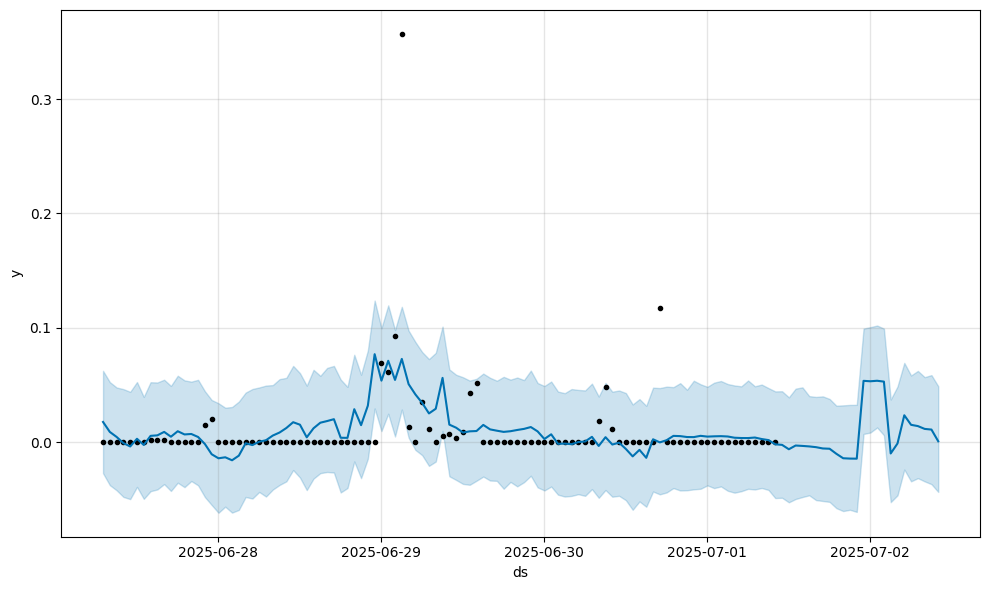

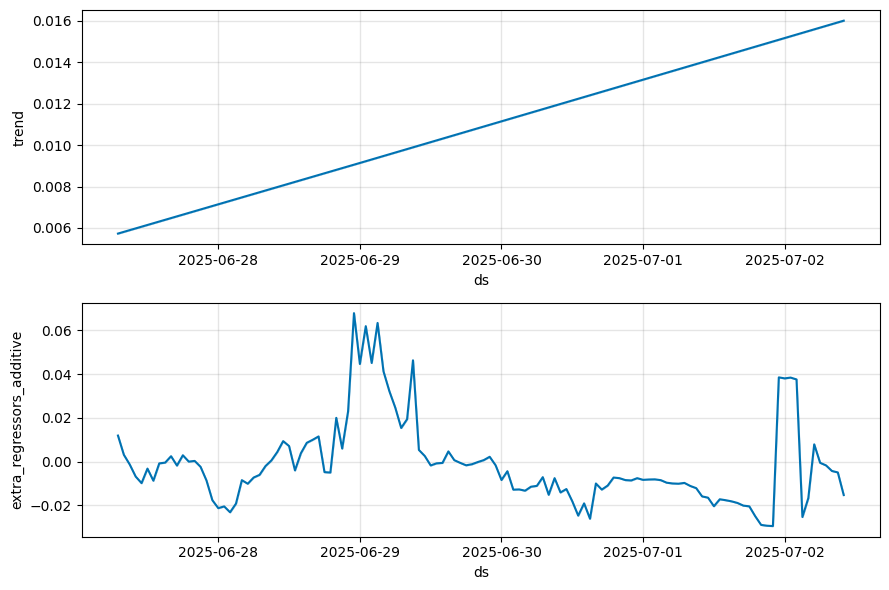

In [44]:
# invert the scaling of the target back to original
# forecast["yhat_original_range"] = forecast['yhat'] * (y_max - y_min) + y_min
forecast['yhat_original_range'] = scaler.inverse_transform(forecast[['yhat']])

# plot some details
fig_forecast = model.plot(forecast)
fig_components = model.plot_components(forecast)

[EXPERIMENT IDEA]: What if we used the Prophet trend value instead of forecast values to determine the overall trends?

In [45]:
# df_full contains the entire original dataset with actual y-values
comparison = forecast[["ds", "yhat", "yhat_lower", "yhat_upper", "yhat_original_range"]].merge(
    df_full[["ds", "y"]],
    on="ds",
    how="left"   # use left join so forecast dates remain, actual y filled where available
)

# Clip values to be >= 0
comparison["y"] = comparison["y"].clip(lower=0)
comparison["yhat"] = comparison["yhat"].clip(lower=0)
comparison["yhat_lower"] = comparison["yhat_lower"].clip(lower=0)
comparison["yhat_upper"] = comparison["yhat_upper"].clip(lower=0)
comparison["yhat_original_range"] = comparison["yhat_original_range"].clip(lower=0)

comparison['y_original_range'] = scaler.inverse_transform(comparison[['y']])


In [46]:
# this thingamajig was happily created by ChatGPT
# not completely sure if always works, let's keep this in mind
def determine_trend(data, threshold):
    # Convert input to a NumPy array if it's not already
    data = np.array(data)

    # Calculate differences between consecutive elements
    differences = np.diff(data)

    # Count the number of upward, downward, and neutral movements
    up_count = np.sum(differences > threshold)
    down_count = np.sum(differences < -threshold)
    # neutral_count = np.sum(np.abs(differences) <= threshold)
    
    # Determine the overall trend based on counts
    if up_count > down_count:
        return "up"
    elif down_count > up_count:
        return "down"
    else:
        return "neutral"

# experiment on the threshold so you can find a good sensitivity for the trends
threshold = 0.005
sample = comparison
trend = determine_trend(sample['yhat_original_range'][-future_horizon:], threshold)
print(f"The overall trend is: {trend}")

immediate_hours = 4

trend = determine_trend(sample['yhat_original_range'][len(df):len(df) + immediate_hours], threshold)
print(f"The immediate trend ({immediate_hours} hours) in forecast is: {trend}")

# analyze overall Prophet trend
start_trend = float(forecast['trend'].iloc[0])
end_trend = float(forecast['trend'].iloc[-1])

if end_trend > start_trend:
    trend = "up"
elif end_trend < start_trend:
    trend = "down"
else:
    trend = "neutral"

# it seems Prophet trend is always towards up??
print(f"The overall Prophet trend evaluation is: {trend}")



The overall trend is: down
The immediate trend (4 hours) in forecast is: neutral
The overall Prophet trend evaluation is: up


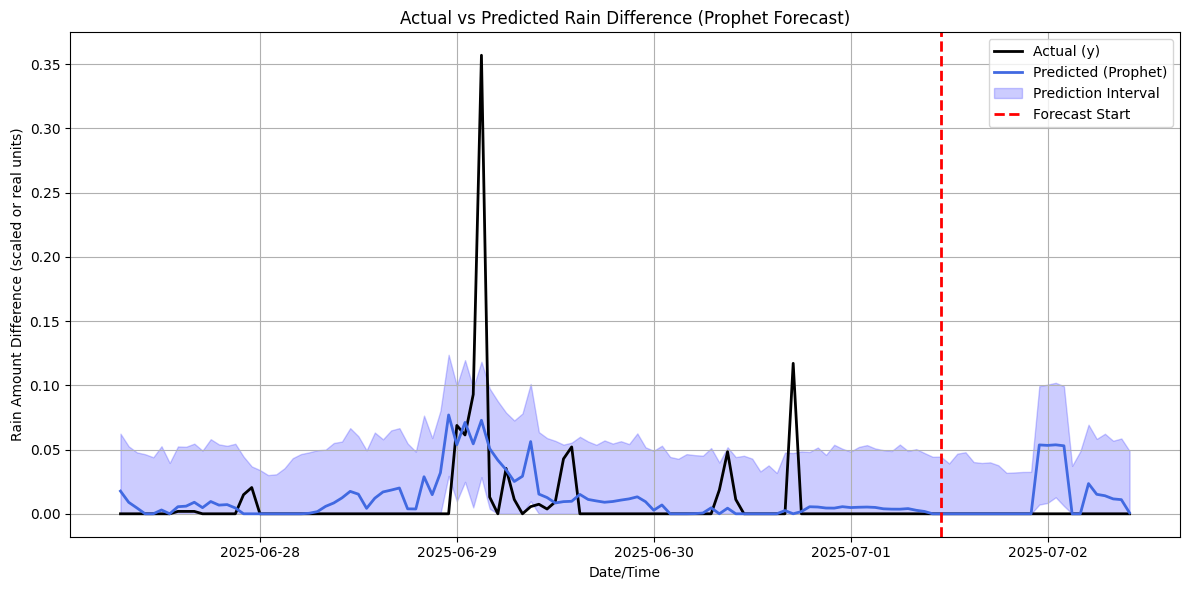

In [47]:
# Determine where the forecast period starts (the last 24 points)
split_index = len(comparison) - future_horizon
split_date = comparison["ds"].iloc[split_index]

plt.figure(figsize=(12, 6))

# Plot actual y
plt.plot(comparison["ds"], comparison["y"], label="Actual (y)", color="black", linewidth=2)

# Plot predicted yhat
plt.plot(comparison["ds"], comparison["yhat"], label="Predicted (Prophet)", color="royalblue", linewidth=2)

# Add Prophet's uncertainty interval
plt.fill_between(
    comparison["ds"],
    comparison["yhat_lower"],
    comparison["yhat_upper"],
    color="blue",
    alpha=0.2,
    label="Prediction Interval"
)

# Add vertical line before future predictions
plt.axvline(
    x=split_date,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Forecast Start"
)

# Labels and legend
plt.title("Actual vs Predicted Rain Difference (Prophet Forecast)")
plt.xlabel("Date/Time")
plt.ylabel("Rain Amount Difference (scaled or real units)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [48]:
# get some quick metrics
mask = ~comparison["y"].isna()
rmse = np.sqrt(mean_squared_error(comparison.loc[mask, "y"], comparison.loc[mask, "yhat"]))
r2 = r2_score(comparison.loc[mask, "y"], comparison.loc[mask, "yhat"])

# preferable RMSE should be close to 0.0 and R-squared as close to 1.0 as possible
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")

RMSE: 0.033
R²:   0.162


### OPTIONAL : inspecting y / yhat -values both scaled and original values

These haven't been tested thoroughly, might have bugs.

In [49]:
# original y, scaled
comparison['y'][-future_horizon:]


100    0.0
101    0.0
102    0.0
103    0.0
104    0.0
105    0.0
106    0.0
107    0.0
108    0.0
109    0.0
110    0.0
111    0.0
112    0.0
113    0.0
114    0.0
115    0.0
116    0.0
117    0.0
118    0.0
119    0.0
120    0.0
121    0.0
122    0.0
123    0.0
Name: y, dtype: float64

In [50]:
# original y, original range (remember, SavGol can force values 
# go to negative too!)
comparison['y_original_range'][-future_horizon:]


100    0.0
101    0.0
102    0.0
103    0.0
104    0.0
105    0.0
106    0.0
107    0.0
108    0.0
109    0.0
110    0.0
111    0.0
112    0.0
113    0.0
114    0.0
115    0.0
116    0.0
117    0.0
118    0.0
119    0.0
120    0.0
121    0.0
122    0.0
123    0.0
Name: y_original_range, dtype: float64

In [51]:
# yhat, scaled
comparison['yhat'][-future_horizon:]

100    0.000000
101    0.000000
102    0.000000
103    0.000000
104    0.000000
105    0.000000
106    0.000000
107    0.000000
108    0.000000
109    0.000000
110    0.000000
111    0.000000
112    0.053607
113    0.053243
114    0.053680
115    0.052930
116    0.000000
117    0.000000
118    0.023514
119    0.015161
120    0.014062
121    0.011598
122    0.011010
123    0.000758
Name: yhat, dtype: float64

In [52]:
# yhat, original range
comparison['yhat_original_range'][-future_horizon:]

100    0.000000
101    0.000000
102    0.000000
103    0.000000
104    0.000000
105    0.000000
106    0.000000
107    0.000000
108    0.000000
109    0.000000
110    0.000000
111    0.000000
112    0.480680
113    0.477413
114    0.481332
115    0.474610
116    0.000000
117    0.000000
118    0.210840
119    0.135943
120    0.126094
121    0.103997
122    0.098723
123    0.006798
Name: yhat_original_range, dtype: float64

In [53]:
# original values in the original dataframe
df_original = df_original.rename({"precipitationIntensity_mm_h": "y"}, axis=1)
df_original = df_original.iloc[index_cut:index_cut + slice_length + future_horizon].copy()
print(f"Amount of selected data points: {len(df_original)}")

print(df_original['y'][-future_horizon:])


Amount of selected data points: 124
200    0.0
201    0.0
202    0.0
203    0.0
204    0.0
205    0.0
206    0.0
207    0.0
208    0.0
209    0.0
210    0.0
211    0.0
212    0.0
213    0.0
214    0.0
215    0.0
216    0.0
217    0.0
218    0.0
219    0.0
220    0.0
221    0.0
222    0.0
223    0.0
Name: y, dtype: float64


### Workshop notes

We need to revise these notes, e.g. DigiTraffic is not practical since they only store last 24 hours of data (we need much older data than that). Would be useful in real production environment though.

In [54]:
# we can use different OpenMeteo variables as extra regressors 
# to "guide" the Prophet forecast

# OTHER IDEAS:
# use different areas to try out the model and analyze if they have any common trends

# idea: combine all sensors in nearby area and get an aggregate (average or sum) of all rain
# activities and try to detect stronger signals that way
# the current measurements have pretty weak signals

In [55]:
# some other ideas (from ChatGPT during the workshop)
# Prophet, LSTM/GRU, RNN ... XGBoost, Random Forest, CatBoost

# Prophet is already used in this notebook
# LSTM/RNN + how to use extra regressors with these, are these better at detecting sudden spikes?

# RandomForest/XGBoost => try skforecast for this, it supports these directly!
# Question: does it support extra future regressors like Prophet?
# probably yes => exog-variables

# one common approach is to also use CNN time series classification => 
# try to predict the moment before an event happens => rain increases
# however, this is probably difficult since most rain data is 0.0
# see the rough sketch with the cnn classification in this Git project

# AI also suggests using data-driven model like Prophet + conventional forecasts as extra regressors
# https://medium.com/data-science/forecast-model-tuning-with-additional-regressors-in-prophet-ffcbf1777dda

# FINALLY: how about using multiple models? Prophet with SavGol, Prophet without SavGol, different
# versions of Prophet with different configurations... RNN/LSTM -models, skforecast models etc. etc.

# Imagine we'd have 10 different models in total => obtain the forecast from each, and take
# the most common prediction => how close is the common prediction to reality (Open Meteo data)

In [56]:
# BASIC IMPLEMENTATION PLAN:

# Use use one local weather station value for y + any number of extra regressors
# experiment with Prophet + LSTM/RNN to see, which algorithm captures abrupt rains the best
# try different time periods, stations and signal lengths
# study the trend visualizations of Prophet and extrapolations from RNN/LSTM

# SEE THE EXPERIMENT IDEAS WITHIN THE CODE COMMENTS IN THIS NOTEBOOK